# Deep Neural Network From Scratch
## Dataset: A-Z Handwritten Alphabets

The link for the dataset is [here](https://www.kaggle.com/datasets/sachinpatel21/az-handwritten-alphabets-in-csv-format)

In [138]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Read in data for analysis
df = pd.read_csv('A_Z Handwritten Data.csv')

# Check data shape
print("Data Shape:", df.shape)

# Check data max and min
print("Data Max and Min:", df.max().max(), df.min().min())

Data Shape: (372450, 785)
Data Max and Min: 255 0


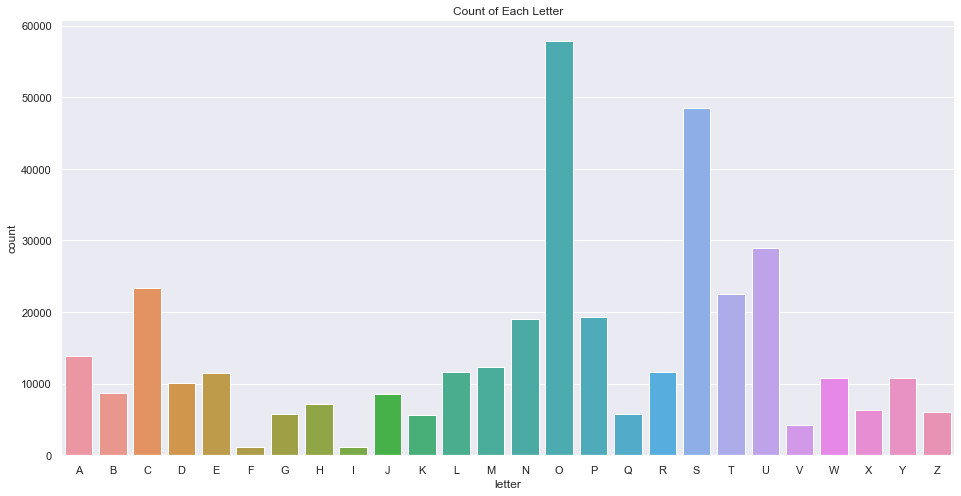

In [142]:
# Set default Seaborn theme
sns.set()

# Create a dataframe for the count of each letter
letters = df['0'].value_counts()
letters = pd.DataFrame(letters)
letters = letters.reset_index()
letters.columns = ['letter', 'count']

# Replace the number with the letter with a lambda function
letters['letter'] = letters['letter'].apply(lambda x: chr(x+65))

# Reorder the letters
letters = letters.sort_values(by='letter')

# Plot the count of each letter
plt.figure(figsize=(16, 8))
sns.barplot(x='letter', y='count', data=letters)
plt.title('Count of Each Letter')
plt.show()

In [104]:
## Step 1: Load and preprocess the dataset, separate for training and testing
def load_data(file_path, percent_train=0.8):
    df = pd.read_csv(file_path)
    # Rearrange rows in random order
    df = df.sample(frac=1).reset_index(drop=True)
    # Assuming the first column is the label and the rest are pixel values
    X = df.iloc[:, 1:].values / 255  # Normalizing pixel values
    y = df.iloc[:, 0].values
    # One-hot encoding, A-Z is 26 classes
    y = one_hot_encode(y, num_classes=26)
    # Splitting into training and testing sets
    X_train = X[:int(percent_train * len(X))]
    y_train = y[:int(percent_train * len(y))]
    X_test = X[int(percent_train * len(X)):]
    y_test = y[int(percent_train * len(y)):]
    return X_train, y_train, X_test, y_test

# One-hot encoding
def one_hot_encode(y, num_classes):
    one_hot = np.zeros((y.size, num_classes))
    one_hot[np.arange(y.size), y] = 1
    return one_hot

# Decoding one-hot encoding to return a value from 0 to num_classes - 1
def one_hot_decode(one_hot):
    # Assuming the one-hot encoding is of shape (num_examples, num_classes)
    # If only one example, reshape to (1, num_classes)
    if len(one_hot.shape) == 1:
        one_hot = one_hot.reshape((1, one_hot.shape[0]))
    return np.argmax(one_hot, axis=1)

# Assign the decoded value to a character from A-Z
def assign_char(one_hot):
    char = chr(ord('A') + int(one_hot_decode(one_hot)))
    return char

# Modified main function
file_path = 'A_Z Handwritten Data.csv'
X_train, y_train, X_test, y_test  = load_data(file_path, percent_train=0.8)

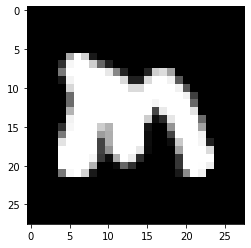

Label: M


In [64]:
# Select a random image from the dataset and display it
example = np.random.randint(0, X_train.shape[0])
# Show the Image of the 28x28 pixel data stored in the 1D array of 784 first columns of the dataset
plt.imshow(X_train[example].reshape((28, 28)), cmap='gray')
plt.show()

# Print the label of the image
print("Label:", assign_char(y_train[example]))


In [89]:
## Step 2: Build a neural network with one hidden layer
# Activation function: Sigmoid
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Derivative of sigmoid
def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

# Mean Squared Error Loss Function
def mse_loss(y_true, y_pred):
    return ((y_true - y_pred) ** 2).mean()

# Neural Network Class
class NeuralNetwork:
    """ A neural network with two hidden layer

    Parameters
    ----------
    input_size: int
        Number of input neurons
    hidden_size1: int
        Number of hidden neurons in the first hidden layer
    hidden_size2: int
        Number of hidden neurons in the second hidden layer
    output_size: int
        Number of output neurons

    Attributes
    ----------
    w1: 2d-array
        First layer weights
    w2: 2d-array
        Second layer weights
    w3: 2d-array
        Third layer weights

    """
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        # Initialize weights and biases for two hidden layers and one output layer
        self.w1 = np.random.randn(input_size, hidden_size1)
        self.w2 = np.random.randn(hidden_size1, hidden_size2)
        self.w3 = np.random.randn(hidden_size2, output_size)

    def forward(self, X):
        # Forward pass through two hidden layers
        self.z1 = np.dot(X, self.w1)
        self.a1 = sigmoid(self.z1)
        self.z2 = np.dot(self.a1, self.w2)
        self.a2 = sigmoid(self.z2)
        self.z3 = np.dot(self.a2, self.w3)
        self.a3 = sigmoid(self.z3)
        return self.a3

    def backprop(self, X, y, learning_rate):
        # Compute gradients
        a3_error = self.a3 - y
        z3_delta = a3_error * sigmoid_derivative(self.z3)
        a2_error = np.dot(z3_delta, self.w3.T)
        z2_delta = a2_error * sigmoid_derivative(self.z2)
        a1_error = np.dot(z2_delta, self.w2.T)
        z1_delta = a1_error * sigmoid_derivative(self.z1)

        # Update weights
        self.w3 -= learning_rate * np.dot(self.a2.T, z3_delta)
        self.w2 -= learning_rate * np.dot(self.a1.T, z2_delta)
        self.w1 -= learning_rate * np.dot(X.T, z1_delta)

    def train(self, X, y, epochs, learning_rate, batch_size):
        # Initialize loss list
        loss = []

        for epoch in range(epochs):
            # Batch training with Stochastic Gradient Descent: Mini-batch size = 26
            # Randomly select 26 training examples and their labels
            idx = np.random.randint(X.shape[0], size=batch_size)
            X_batch = X[idx]
            y_batch = y[idx]

            # Forward propagation for each training example
            output = self.forward(X_batch)
            # Backpropagation for each training example
            self.backprop(X_batch, y_batch, learning_rate)

            # Calculate loss every 100 iterations, keep track of the loss
            if epoch % 100 == 0:
                if epoch == 0:
                    prev_loss = mse_loss(y_batch, output)
                else:
                    prev_loss = loss[-1]
                loss.append(mse_loss(y_batch, output))
                # Print loss
                print("Epoch:", epoch, "Loss:", loss[-1])
                # If there is no change in loss, stop training
                if epoch > 0 and loss[-1] == prev_loss:
                    print("Epoch:", epoch, "Loss:", loss[-1], "Prev Loss:", prev_loss)
                    print("No change in loss. Stop training.")
                    return loss
                
        return loss

In [109]:
## Step 3: Train the neural network
input_size = X_train.shape[1]
hidden_size1 = 64 # You can change this
hidden_size2 = 32 # You can change this
output_size = y_train.shape[1]

nn = NeuralNetwork(input_size, hidden_size1, hidden_size2, output_size)
loss = nn.train(X_train, y_train, epochs=10000, learning_rate=0.01, batch_size=100)


Epoch: 0 Loss: 0.3545136524277124
Epoch: 100 Loss: 0.036896729342478826
Epoch: 200 Loss: 0.03273717742922301
Epoch: 300 Loss: 0.030648948009301003
Epoch: 400 Loss: 0.030461164764203668
Epoch: 500 Loss: 0.029369626716661962
Epoch: 600 Loss: 0.029318919523338052
Epoch: 700 Loss: 0.030182624546123058
Epoch: 800 Loss: 0.03052033023842913
Epoch: 900 Loss: 0.028199871859024478
Epoch: 1000 Loss: 0.02405577432668581
Epoch: 1100 Loss: 0.02670186093120374
Epoch: 1200 Loss: 0.02289281039324983
Epoch: 1300 Loss: 0.025186439592135595
Epoch: 1400 Loss: 0.029116546927505958
Epoch: 1500 Loss: 0.024835276104750854
Epoch: 1600 Loss: 0.0234437556770718
Epoch: 1700 Loss: 0.023199328895570935
Epoch: 1800 Loss: 0.025144696178907532
Epoch: 1900 Loss: 0.023999527025756792
Epoch: 2000 Loss: 0.024377568590142413
Epoch: 2100 Loss: 0.024692768168697227
Epoch: 2200 Loss: 0.025198122873041653
Epoch: 2300 Loss: 0.02563236266695679
Epoch: 2400 Loss: 0.024053923267886447
Epoch: 2500 Loss: 0.02344912679755913
Epoch: 26

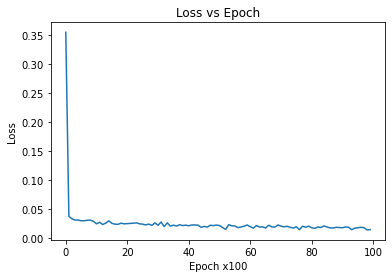

In [110]:
# Plot loss vs epochs
plt.plot(loss)
plt.xlabel("Epoch x100")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.show()


In [111]:
# Predicting 10 random samples and comparing with actual labels
for i in range(10):
    index = np.random.randint(0, X_test.shape[0])
    pred = nn.forward(X_test[index])
    print("Predicted:", assign_char(pred), "Actual:", assign_char(y_test[index]))

Predicted: U Actual: U
Predicted: D Actual: U
Predicted: U Actual: H
Predicted: T Actual: T
Predicted: D Actual: J
Predicted: E Actual: H
Predicted: S Actual: S
Predicted: R Actual: B
Predicted: O Actual: O
Predicted: A Actual: A


In [112]:
# Calculate accuracy on test set
pred = nn.forward(X_test)
pred = one_hot_decode(pred)
y_test = one_hot_decode(y_test)
acc = np.mean(pred == y_test)
print("Accuracy on test set:", acc)

Accuracy on test set: 0.6551214928178279
